Here, a system of n spins coupled via sigma^+, sigma^- gates is considered where every m-th spin can be (projectively) measured along an axis of angles theta, phi. The measurement angles and couplings are the control parameters.

In [ ]:
# Add the feedback-grape git submodule to the path
import sys, os
sys.path.append(os.path.abspath("./feedback-grape-dev"))

from feedback_grape.utils.operators import (
    sigmax,
    sigmay,
    sigmaz,
    sigmap,
    sigmam,
)
from feedback_grape.utils.states import basis
from feedback_grape.utils.tensor import tensor
from feedback_grape.fgrape import optimize_pulse, Gate, Decay
import jax
from jax import numpy as jnp
from numpy import flip
from library.utils.qubit_chain_1D import embed, calculate_expected_fidelity
from library.utils.plot_matrix import plot_matrix
from tqdm import tqdm
from jax.scipy.linalg import expm
from math import ceil

# Training parameters
N_timesteps = range(1,6) # Number of time steps to test
N_samples = 5 # Number of random initializations to test
N_training_iterations = 1000 # Number of training iterations
learning_rate = 0.02 # Learning rate

# System parameters
n = 5 # Number of qubits
measurement_sites = [0, 3] # Sites where measurements are performed (0-indexed)
flip_sites = [2, 4] # Sites to be flipped (0-indexed)
control_qubit = 0 # Qubit where control rotations are applied (0-indexed)
decay_constant = jnp.sqrt(0.005) # Decay constant for amplitude damping

# Initialize ground state density matrix (all spins down)
rho_ground = basis(2**n, 0) @ basis(2**n, 0).conj().T

# Target state with excitation at flip_sites
psi = basis(2**n, 0)
for k in flip_sites:
    psi = embed(sigmax(), k, n) @ psi
rho_excited = psi @ psi.conj().T
rho_excited /= jnp.trace(rho_excited) # Normalize

# Control operators (bloch rotation on control qubit and sigmam, sigmap between neighboring qubits)
def transport_unitary(params):
    return expm(-1j*sum([
        -t*embed(sigmap(), i, n)@embed(sigmam(), i+1, n) - t*embed(sigmam(), i, n)@embed(sigmap(), i+1, n)
        for i,t in enumerate(params)
    ]))

def initialize_transport_gates(key):
    return Gate(
        gate = transport_unitary,
        initial_params=jax.random.uniform(
            jax.random.PRNGKey(key),
            shape=(n-1,), # n-1 couplings
            minval=0.0,
            maxval=1.0,
            dtype=float,
        ),
        measurement_flag=False,
    )

def rotation_unitary(params):
    alpha, beta = params
    return expm(-1j*(alpha*embed(sigmax(), control_qubit, n) + beta*embed(sigmay(), control_qubit, n)))

def initialize_rotation_gate(key):
    return Gate(
        gate = rotation_unitary,
        initial_params=jax.random.uniform(
            jax.random.PRNGKey(key),
            shape=(2,), # alpha, beta
            minval=-jnp.pi,
            maxval=jnp.pi,
            dtype=float,
        ),
        measurement_flag=False,
    )

# Measurement operator (projective measurement along axis defined by theta, phi)
def povm(measurement_outcome, params, k):
    theta, phi = params
    x,y,z = jnp.sin(theta)*jnp.cos(phi), jnp.sin(theta)*jnp.sin(phi), jnp.cos(theta)

    S = x*sigmax() + y*sigmay() + z*sigmaz()
    P1 = (jnp.eye(2) + S)/2
    P2 = (jnp.eye(2) - S)/2

    return jnp.where(
        measurement_outcome == 1,
        embed(P1, k, n),
        embed(P2, k, n),
    )

def initialize_povm_gates(key):
    povm_gates = []
    for k in measurement_sites:
        povm_gates.append(
            Gate(
                gate = lambda measurement_outcome, params, k=k: povm(measurement_outcome, params, k) + povm(measurement_outcome, params, k),
                initial_params=jax.random.uniform(
                    jax.random.PRNGKey(key+i),
                    shape=(2,), # theta, phi
                    minval=-jnp.pi,
                    maxval=jnp.pi,
                    dtype=float,
                ),
                measurement_flag=True,
            )
        )

    return povm_gates

# Decay operator (amplitude damping on all qubits)
decay_gate = Decay(c_ops=[decay_constant * embed(sigmap(), k, n) for k in range(n)])

# Assert that measurement operator is valid
assert jnp.allclose(povm(-1, (0, 0), 0) + povm(1, (0, 0), 0), jnp.eye(2**n)), "Measurement operators do not sum to identity"

fidelity_lists  = []
fidelity_labels = []

In [ ]:
best_result = None
for num_time_steps in N_timesteps: # Number of time steps to test
    print(f"Running for {num_time_steps} time steps")
    fidelity_list = []
    for i in tqdm(range(N_samples)):
        # Initialize time evolution operators (measurements followed by rotation on control qubit and transport)
        #system_params = initialize_povm_gates(key=i) + [initialize_rotation_gate(key=i), initialize_transport_gates(key=i)]
        system_params = initialize_povm_gates(key=i) + [decay_gate, initialize_transport_gates(key=i), decay_gate]

        # Training
        result = optimize_pulse(
            U_0=rho_ground,
            C_target=rho_excited,
            system_params=system_params,
            num_time_steps=num_time_steps,
            mode="lookup",
            goal="fidelity",
            max_iter=N_training_iterations,
            convergence_threshold=1e-6,
            learning_rate=learning_rate,
            evo_type="density",
            batch_size=8,
            eval_batch_size=10,
        )

        fidelity_list.append(result.final_fidelity)
        
    print(f"Max fidelity for {num_time_steps} time steps: {max(fidelity_list)}")
    fidelity_lists.append(fidelity_list)
    fidelity_labels.append(f"t={num_time_steps} (1)")

# Play a sound when done
import os
os.system('say "fertig"')

# Concatenate with previous results for plotting
fidelity_lists = (
      [[0.25002643878923675], [0.5624969306225057], [0.6816929873851241], [0.7720503758240014], [0.8550823259569829]]
    + [[0.4999999973908317], [0.7500633471451231], [0.8536009813860631], [0.9999920512541073], [0.9999997167579313]]
    + [[0.0], [2.5801357614596514e-06], [0.9999973956817952], [0.9999948435944875], [0.9999776833249817]]
    + [[0.0], [2.5035316437091724e-06], [0.9512269420962641], [0.9511000789262692], [0.9511609314821533]]
    + [[0.0], [0.0], [0.0], [0.0], [0.0]]
    + [[0.4900993340960943], [0.7258743117630148], [0.824915851453312], [0.9607855880379527], [0.9512279748052042]]
    + fidelity_lists
)
fidelity_labels = (
      ["t=1 (0)", "t=2 (0)", "t=3 (0)", "t=4 (0)", "t=5 (0)"] # (control qubit:  no, povm: yes, decay:  no) (MT)^N
    + ["t=1 (1)", "t=2 (1)", "t=3 (1)", "t=4 (1)", "t=5 (1)"] # (control qubit: yes, povm: yes, decay:  no) (MRT)^N
    + ["t=1 (2)", "t=2 (2)", "t=3 (2)", "t=4 (2)", "t=5 (2)"] # (control qubit: yes, povm:  no, decay:  no) (RT)^N
    + ["t=1 (3)", "t=2 (3)", "t=3 (3)", "t=4 (3)", "t=5 (3)"] # (control qubit: yes, povm:  no, decay: yes) (RDTD)^N
    + ["t=1 (4)", "t=2 (4)", "t=3 (4)", "t=4 (4)", "t=5 (4)"] # (control qubit:  no, povm:  no, decay: yes) (DTD)^N
    + ["t=1 (5)", "t=2 (5)", "t=3 (5)", "t=4 (5)", "t=5 (5)"] # (control qubit: yes, povm: yes, decay: yes) (MRDTD)^N
    + ["t=1 (6)", "t=2 (6)", "t=3 (6)", "t=4 (6)", "t=5 (6)"] # (control qubit:  no, povm: yes, decay: yes) (MDTD)^N
    + fidelity_labels
)

Running for 1 time steps


100%|██████████| 5/5 [02:22<00:00, 28.41s/it]


Max fidelity for 1 time steps: 0.24505951399281717
Running for 2 time steps


100%|██████████| 5/5 [08:08<00:00, 97.76s/it] 


Max fidelity for 2 time steps: 0.5483337732988193
Running for 3 time steps


100%|██████████| 5/5 [17:06<00:00, 205.33s/it]


Max fidelity for 3 time steps: 0.5767591171468814
Running for 4 time steps


100%|██████████| 5/5 [24:04<00:00, 288.85s/it]


Max fidelity for 4 time steps: 0.6972208416561668
Running for 5 time steps


  0%|          | 0/5 [00:00<?, ?it/s]2025-09-25 15:53:29.104864: E external/xla/xla/service/slow_operation_alarm.cc:73] 
********************************
[Compiling module jit_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-09-25 15:53:59.200914: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 2m30.10302s

********************************
[Compiling module jit_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
 20%|██        | 1/5 [16:48<1:07:12, 1008.20s/it]2025-09-25 16:10:21.421940: E external/xla/xla/service/slow_operation_alarm.cc:73] 
********************************
[Compiling module jit_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
************************

max fidelity: t=1 (0) 0.4900993340960943
max fidelity: t=2 (0) 0.7258743117630148
max fidelity: t=3 (0) 0.824915851453312
max fidelity: t=4 (0) 0.9607855880379527
max fidelity: t=5 (0) 0.9512279748052042


(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

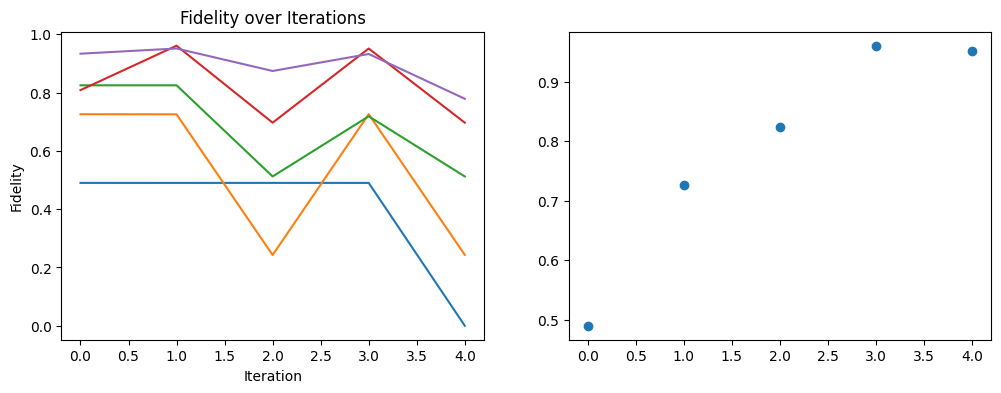

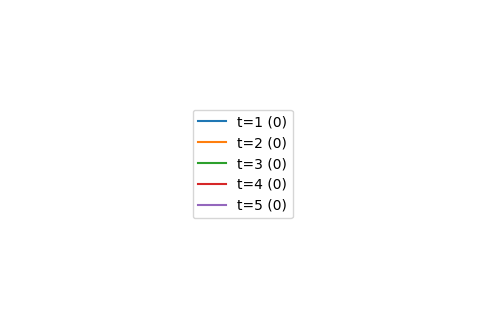

In [7]:
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
for fidelities, label in zip(fidelity_lists, fidelity_labels):
    ax1.plot(fidelities, label=label)
    print(f"max fidelity: {label}", max(fidelities))
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Fidelity")
ax1.set_title("Fidelity over Iterations")

ax2.plot([max(fidelities) for fidelities in fidelity_lists], label=label, marker="o", linestyle='None')

# legend in seperate figure
fig2, ax2 = plt.subplots(1,1, figsize=(6,4))
ax2.legend(*ax1.get_legend_handles_labels(), loc='center')
ax2.axis('off')

In [6]:
a = [0.25002643878923675, 0.5624969306225057, 0.6816929873851241, 0.7720503758240014, 0.8550823259569829]